In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, log_loss
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from source.validate import random_split, yearly_split
from source.report import report_points, report_victory, yearly_wrapper

from source.train_funcs import train_model
from source.report import _point_to_proba
from source.validate import _make_preds

In [2]:
kfolds = KFold(n_splits=7, shuffle=True, random_state=23)

In [5]:
df = pd.read_csv('data/processed_women/training_data.csv')

df['seed_round1'] = 0
df['seed_round2'] = 0

df.loc[(df.T1_Seed < 5) & (df.stage_Round1 == 1), 'seed_round1'] = 1
df.loc[(df.T1_Seed < 2) & (df.stage_Round2 == 1), 'seed_round2'] = 1

df['off_edge_Seed'] = df['delta_Seed'] * df['delta_off_edge']
df['def_edge_Seed'] = df['delta_Seed'] * df['delta_def_edge']

df['T1_DR_edge'] = df['T1_DR_opportunity'] - df['T2_OR_opportunity']
df['T2_DR_edge'] = df['T2_DR_opportunity'] - df['T1_OR_opportunity']
df['delta_DR_edge'] = df['T1_DR_edge'] - df['T2_DR_edge']

df['T1_OR_edge'] = df['T1_OR_opportunity'] - df['T2_DR_opportunity']
df['T2_OR_edge'] = df['T2_OR_opportunity'] - df['T1_DR_opportunity']
df['delta_OR_edge'] = df['T1_OR_edge'] - df['T2_OR_edge']

train_df = df.copy()

train_df.head()

,Season,DayNum,Team1,Team2,target,target_points,T1_Loc,T2_Loc,ID,T1_Ast,...,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed,T1_DR_edge,T2_DR_edge,delta_DR_edge,T1_OR_edge,T2_OR_edge,delta_OR_edge
0,2010,138,3124,3201,1,14,0,0,2010_3124_3201,14.687500,...,1,0,-139.557216,-198.297310,0.361078,0.316318,0.044760,-0.316318,-0.361078,0.044760
1,2010,138,3173,3395,1,1,0,0,2010_3173_3395,14.461538,...,0,0,-15.091164,-16.370410,0.394133,0.273866,0.120267,-0.273866,-0.394133,0.120267
2,2010,138,3181,3214,1,35,1,-1,2010_3181_3214,14.250000,...,1,0,-237.910945,-188.939757,0.357474,0.265349,0.092125,-0.265349,-0.357474,0.092125
3,2010,138,3199,3256,1,14,1,-1,2010_3199_3256,15.333333,...,1,0,-178.484610,-177.421684,0.307223,0.308977,-0.001754,-0.308977,-0.307223,-0.001754
4,2010,138,3207,3265,1,20,0,0,2010_3207_3265,15.866667,...,0,0,-80.862538,-122.529105,0.347945,0.257592,0.090353,-0.257592,-0.347945,0.090353


In [6]:
df = pd.read_csv('data/processed_women/2022_test_data.csv')
df.loc[:,'ID'] = df.Season.astype(str) + '_' + df.Team1.astype(str) + '_' + df.Team2.astype(str)

df['seed_round1'] = 0
df['seed_round2'] = 0

df.loc[(df.T1_Seed < 5) & (df.stage_Round1 == 1), 'seed_round1'] = 1
df.loc[(df.T1_Seed < 2) & (df.stage_Round2 == 1), 'seed_round2'] = 1

df['off_edge_Seed'] = df['delta_Seed'] * df['delta_off_edge']
df['def_edge_Seed'] = df['delta_Seed'] * df['delta_def_edge']

df['T1_DR_edge'] = df['T1_DR_opportunity'] - df['T2_OR_opportunity']
df['T2_DR_edge'] = df['T2_DR_opportunity'] - df['T1_OR_opportunity']
df['delta_DR_edge'] = df['T1_DR_edge'] - df['T2_DR_edge']

df['T1_OR_edge'] = df['T1_OR_opportunity'] - df['T2_DR_opportunity']
df['T2_OR_edge'] = df['T2_OR_opportunity'] - df['T1_DR_opportunity']
df['delta_OR_edge'] = df['T1_OR_edge'] - df['T2_OR_edge']

test_df = df.copy()

test_df.head()

,Team1,Team2,Pred,Season,T1_Ast,T1_Ast_diff,T1_Away,T1_Blk,T1_Blk_diff,T1_DR,...,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed,T1_DR_edge,T2_DR_edge,delta_DR_edge,T1_OR_edge,T2_OR_edge,delta_OR_edge
0,3107,3110,0.5,2022,12.645161,2.612903,0.225806,3.483871,0.387097,21.387097,...,0,0,13.468979,19.402832,0.449367,0.347629,0.101738,-0.347629,-0.449367,0.101738
1,3107,3112,0.5,2022,12.645161,2.612903,0.225806,3.483871,0.387097,21.387097,...,0,0,79.040858,245.319288,0.403408,0.333109,0.070299,-0.333109,-0.403408,0.070299
2,3107,3116,0.5,2022,12.645161,2.612903,0.225806,3.483871,0.387097,21.387097,...,0,0,5.103912,118.893287,0.439219,0.336571,0.102648,-0.336571,-0.439219,0.102648
3,3107,3124,0.5,2022,12.645161,2.612903,0.225806,3.483871,0.387097,21.387097,...,0,0,97.099528,390.216720,0.374411,0.381861,-0.007450,-0.381861,-0.374411,-0.007450
4,3107,3125,0.5,2022,12.645161,2.612903,0.225806,3.483871,0.387097,21.387097,...,0,0,29.270914,96.037326,0.372490,0.349646,0.022844,-0.349646,-0.372490,0.022844


In [7]:
to_use = ['ID', 'target', 'Season', 'target_points']

d_car = []
t_car = ['Score', 'opp_score', 'FGM_perc', 'Seed', 'Stl', 
         'Blk', 'Ast', 'off_rating', 'def_rating', 'TO', 'Away']
l2wd_car = []
l2wt_car = []

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in l2wt_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    
to_use += ['seed_round1', 'off_edge_Seed', 'def_edge_Seed']

to_use_xgb = to_use

to_use_xgb

['ID',
 'target',
 'Season',
 'target_points',
 'T1_Score',
 'T2_Score',
 'T1_opp_score',
 'T2_opp_score',
 'T1_FGM_perc',
 'T2_FGM_perc',
 'T1_Seed',
 'T2_Seed',
 'T1_Stl',
 'T2_Stl',
 'T1_Blk',
 'T2_Blk',
 'T1_Ast',
 'T2_Ast',
 'T1_off_rating',
 'T2_off_rating',
 'T1_def_rating',
 'T2_def_rating',
 'T1_TO',
 'T2_TO',
 'T1_Away',
 'T2_Away',
 'seed_round1',
 'off_edge_Seed',
 'def_edge_Seed']

In [8]:
to_use = ['ID', 'target', 'Season']

d_car = ['Score', 'opp_score', 'Blk', 'Stl',
         'def_rating', 'possessions']
t_car = []
l2wd_car = []
l2wt_car = []

for c in d_car:
    to_use += [f'delta_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_{c}', f'T2_{c}']
    
for c in l2wd_car:
    to_use += [f'delta_L2W_{c}'] # f'T1_{c}', f'T2_{c}', 
    
for c in t_car:
    to_use += [f'T1_L2W_{c}', f'T2_L2W_{c}']
    

to_use += ['seed_round1', 'seed_round2', 'off_edge_Seed', 'def_edge_Seed']

to_use_logit = to_use

to_use_logit

['ID',
 'target',
 'Season',
 'delta_Score',
 'delta_opp_score',
 'delta_Blk',
 'delta_Stl',
 'delta_def_rating',
 'delta_possessions',
 'seed_round1',
 'seed_round2',
 'off_edge_Seed',
 'def_edge_Seed']

# Logit Training

In [9]:
logit_target = train_df['target']
logit_index = train_df[['ID', 'Team1', 'Team2', 'target', 'Season']].copy()
logit_train = train_df[[col for col in to_use_logit if col not in ['ID', 'Team1', 'Team2', 'target', 'Season']]].copy()
logit_train.head()

,delta_Score,delta_opp_score,delta_Blk,delta_Stl,delta_def_rating,delta_possessions,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed
0,-1.360795,-3.732008,4.643939,-3.425189,-4.065292,0.432765,1,0,-139.557216,-198.297310
1,-1.530769,-0.800000,0.476923,-2.102564,-0.424508,-0.581346,0,0,-15.091164,-16.370410
2,8.760417,-0.070833,3.047917,3.275000,-2.671770,3.851719,1,0,-237.910945,-188.939757
3,0.208602,-4.222581,0.291398,1.736559,-2.345643,-1.711667,1,0,-178.484610,-177.421684
4,-0.148485,0.457576,-1.884848,5.487879,-2.361552,2.631364,0,0,-80.862538,-122.529105


In [10]:
logit_res = test_df[['ID', 'Team1', 'Team2', 'Season']].copy()
logit_test = test_df[[col for col in to_use_logit if col not in ['ID', 'Team1', 'Team2', 'target', 'Season']]].copy()
logit_test.head()

,delta_Score,delta_opp_score,delta_Blk,delta_Stl,delta_def_rating,delta_possessions,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed
0,-3.709677,-7.064516,1.096774,-0.387097,-4.404561,-5.376613,0,0,13.468979,19.402832
1,-11.529271,-7.847073,-0.479092,-2.449223,-4.552312,-5.553256,0,0,79.040858,245.319288
2,-17.419355,-16.741935,-1.483871,0.677419,-10.288399,-12.084677,0,0,5.103912,118.893287
3,-20.677419,-11.517107,-0.455523,1.335288,-4.203370,-9.746774,0,0,97.099528,390.216720
4,-13.160178,-6.549499,-0.895439,-0.898776,-3.821322,-4.708843,0,0,29.270914,96.037326


In [11]:
logit_pipe = Pipeline([('scl', tml.DfScaler(method='robust')),
                 ('logit', LogisticRegression(random_state=23, C=0.04))])

In [12]:
grid_param = {'logit__C': np.arange(1, 20, 0.5), 'scl__method': ['robust','standard']}

res, bp, be = tml.grid_search(logit_train, logit_target, logit_pipe, grid_param, 'neg_log_loss', kfolds)

print(bp)

res

{'logit__C': 10.5, 'scl__method': 'standard'}


,param_logit__C,param_scl__method,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,10.5,standard,-0.416325,0.004615,-0.423251,0.027102,0.016723,0.004435,0.004409,0.002911
1,10.0,standard,-0.416331,0.004615,-0.423252,0.027091,0.014049,0.000408,0.004314,0.002857
2,11.0,standard,-0.416320,0.004616,-0.423252,0.027112,0.022045,0.017765,0.003511,0.000355
3,11.5,standard,-0.416316,0.004617,-0.423252,0.027121,0.015205,0.000954,0.003213,0.000104
4,9.5,standard,-0.416337,0.004614,-0.423253,0.027079,0.014122,0.000676,0.003191,0.000080
...,...,...,...,...,...,...,...,...,...,...
71,1.0,standard,-0.417600,0.004509,-0.423987,0.026607,0.013040,0.000308,0.003406,0.000214
72,2.5,robust,-0.417813,0.004556,-0.424099,0.027070,0.014523,0.000540,0.003168,0.000052
73,2.0,robust,-0.418132,0.004549,-0.424336,0.027098,0.014821,0.000584,0.003199,0.000057
74,1.5,robust,-0.418590,0.004543,-0.424687,0.027152,0.014331,0.000642,0.003289,0.000127


In [13]:
logit_pipe = Pipeline([('scl', tml.DfScaler(method='standard')),
                 ('logit', LogisticRegression(random_state=23, C=10.5))])

In [14]:
_, logit_index['oof_pred'], feat_imp, logit_res['logit_pred'] = _make_preds(logit_train, logit_target, logit_test, logit_pipe, kfolds, predict_proba=True)
feat_imp

,mean,std
feat,,
delta_opp_score,-2.329386,0.073947
delta_def_rating,1.834576,0.065191
seed_round2,0.910431,0.009267
def_edge_Seed,-0.885959,0.032300
delta_possessions,0.809313,0.037013
seed_round1,0.734930,0.039101
off_edge_Seed,-0.724973,0.034239
delta_Score,0.683540,0.008185
delta_Blk,0.379851,0.010139


In [15]:
logit_index.head()

,ID,Team1,Team2,target,Season,oof_pred
0,2010_3124_3201,3124,3201,1,2010,0.991338
1,2010_3173_3395,3173,3395,1,2010,0.512749
2,2010_3181_3214,3181,3214,1,2010,0.998246
3,2010_3199_3256,3199,3256,1,2010,0.990309
4,2010_3207_3265,3207,3265,1,2010,0.647250


<AxesSubplot:>

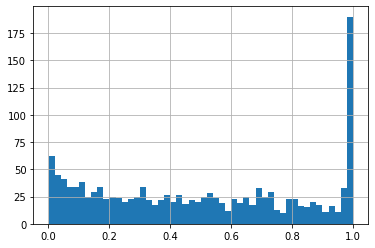

In [16]:
logit_index['oof_pred'].hist(bins=50)

Accuracy train: 		 0.7965
Accuracy test: 			 0.7965
Logloss train: 			 0.4266
Logloss test: 			 0.4266
Unsure train: 			 15.4401%
Unsure test: 			 15.4401%


,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test
0,0.7965,0.7965,0.4266,0.4266,15.4401,15.4401


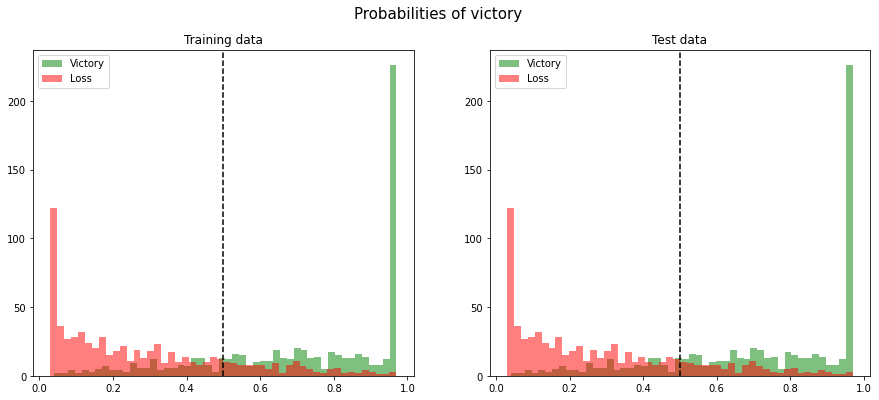

In [17]:
report_victory(logit_target, logit_target, logit_index['oof_pred'], logit_index['oof_pred'], probs=True, plot=True)

In [18]:
logit_res.head()

,ID,Team1,Team2,Season,logit_pred
0,2022_3107_3110,3107,3110,2022,0.508802
1,2022_3107_3112,3107,3112,2022,0.079158
2,2022_3107_3116,3107,3116,2022,0.201741
3,2022_3107_3124,3107,3124,2022,0.033674
4,2022_3107_3125,3107,3125,2022,0.175972


<AxesSubplot:>

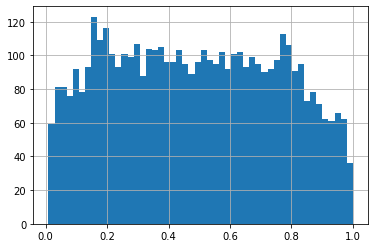

In [19]:
logit_res.logit_pred.hist(bins=50)

# XGB train

In [20]:
def cauchyobj(labels, preds):
    c = 7000 
    x =  preds - labels    
    grad = x / (x**2 / c**2 + 1)
    hess = - c**2 *(x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

In [21]:
xgb_target = train_df['target_points']
xgb_index = train_df[['ID', 'Team1', 'Team2', 'target_points', 'target', 'Season']].copy()
xgb_train = train_df[[col for col in to_use_xgb if col not in ['ID', 'Team1', 'Team2', 'target', 'target_points', 'Season']]].copy()
xgb_train.head()

,T1_Score,T2_Score,T1_opp_score,T2_opp_score,T1_FGM_perc,T2_FGM_perc,T1_Seed,T2_Seed,T1_Stl,T2_Stl,...,T2_off_rating,T1_def_rating,T2_def_rating,T1_TO,T2_TO,T1_Away,T2_Away,seed_round1,off_edge_Seed,def_edge_Seed
0,72.093750,73.454545,56.843750,60.575758,0.463117,0.419783,4.0,13.0,6.968750,10.393939,...,101.762731,79.729697,83.794988,16.875000,15.636364,0.250000,0.424242,1,-139.557216,-198.297310
1,70.769231,72.300000,59.500000,60.300000,0.420625,0.414882,8.0,9.0,7.730769,9.833333,...,98.150641,81.780231,82.204739,16.961538,16.033333,0.461538,0.233333,0,-15.091164,-16.370410
2,71.593750,62.833333,55.062500,55.133333,0.421078,0.369384,2.0,15.0,13.375000,10.100000,...,90.589453,76.055626,78.727396,17.906250,15.533333,0.312500,0.300000,1,-237.910945,-188.939757
3,74.466667,74.258065,60.100000,64.322581,0.445946,0.434469,3.0,14.0,8.833333,7.096774,...,98.074971,81.945727,84.291370,19.033333,17.096774,0.333333,0.451613,1,-178.484610,-177.421684
4,68.033333,68.181818,58.366667,57.909091,0.395465,0.420566,5.0,12.0,13.366667,7.878788,...,100.914559,83.410401,85.771953,16.300000,13.484848,0.400000,0.242424,0,-80.862538,-122.529105


In [22]:
xgb_index.shape

(1386, 6)

In [23]:
xgb_res = test_df[['ID', 'Team1', 'Team2', 'Season']].copy()
xgb_test = test_df[[col for col in to_use_xgb if col not in ['ID', 'Team1', 'Team2', 'target', 'target_points', 'Season']]].copy()
xgb_test.head()

,T1_Score,T2_Score,T1_opp_score,T2_opp_score,T1_FGM_perc,T2_FGM_perc,T1_Seed,T2_Seed,T1_Stl,T2_Stl,...,T2_off_rating,T1_def_rating,T2_def_rating,T1_TO,T2_TO,T1_Away,T2_Away,seed_round1,off_edge_Seed,def_edge_Seed
0,56.322581,60.032258,48.967742,56.032258,0.409233,0.421781,16.0,14.0,8.032258,8.419355,...,87.941863,78.240447,82.645008,15.451613,14.806452,0.225806,0.225806,0,13.468979,19.402832
1,56.322581,67.851852,48.967742,56.814815,0.409233,0.434699,16.0,4.0,8.032258,10.481481,...,98.683721,78.240447,82.792759,15.451613,12.074074,0.225806,0.296296,0,79.040858,245.319288
2,56.322581,73.741935,48.967742,65.709677,0.409233,0.410296,16.0,10.0,8.032258,7.354839,...,98.055995,78.240447,88.528845,15.451613,10.870968,0.225806,0.193548,0,5.103912,118.893287
3,56.322581,77.000000,48.967742,60.484848,0.409233,0.459821,16.0,2.0,8.032258,6.696970,...,106.113070,78.240447,82.443817,15.451613,12.393939,0.225806,0.393939,0,97.099528,390.216720
4,56.322581,69.482759,48.967742,55.517241,0.409233,0.437094,16.0,12.0,8.032258,8.931034,...,102.249778,78.240447,82.061769,15.451613,12.379310,0.225806,0.413793,0,29.270914,96.037326


In [24]:
proc_pipe = Pipeline([('scl', tml.DfImputer())])
# estimator = xgb.XGBRegressor(learning_rate=0.01, n_estimators=2000, objective=cauchyobj, max_depth=3,
#                                            n_jobs=5, subsample=0.5, reg_alpha=0, reg_lambda=10, colsample_bytree=0.7)
estimator = xgb.XGBRegressor(learning_rate=0.01, n_estimators=4000, objective=cauchyobj, max_depth=48,
                                           n_jobs=5, subsample=0.12, reg_alpha=0.02, reg_lambda=0, colsample_bytree=0.86)


xgb_index['oof_pointpred'], xgb_res['xgb_pointpred'], rep_res = train_model(xgb_train, xgb_test, xgb_target,
                                                                       proc_pipe, estimator, kfolds, early_stopping=200, eval_metric='mae')

In [25]:
rep_res['n_iterations']

[427, 446, 270, 266, 398, 488, 496]

In [26]:
rep_res['feat_imp']

,mean,std
feat,,
def_edge_Seed,0.152852,0.004993
seed_round1,0.135459,0.015591
off_edge_Seed,0.123791,0.003005
T1_off_rating,0.038423,0.000856
T2_off_rating,0.036554,0.000860
T2_Ast,0.035134,0.001181
T1_def_rating,0.034427,0.001336
T2_Seed,0.034392,0.001340
T2_def_rating,0.034226,0.001010


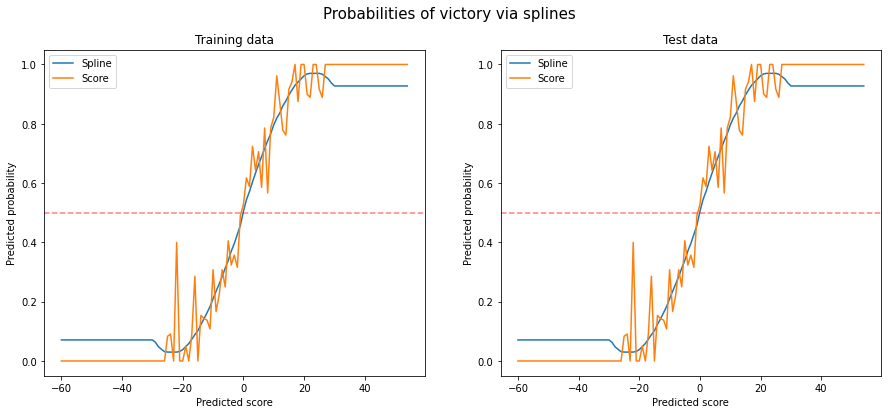

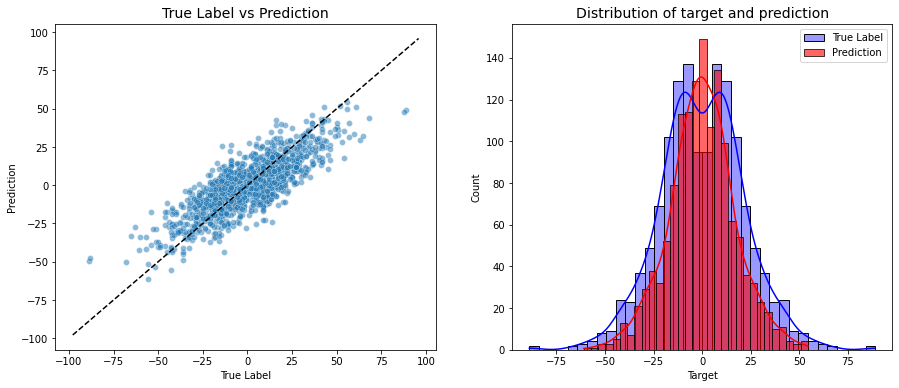

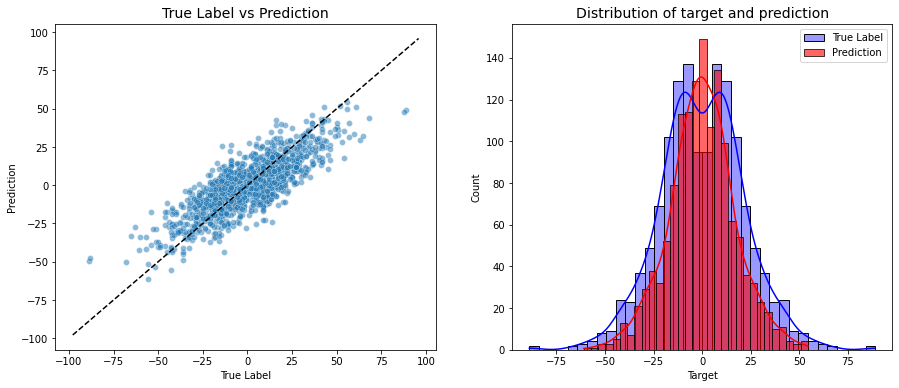

MAE train: 			 10.1168
MAE test: 			 10.1168
RMSE train: 			 12.7311
RMSE test: 			 12.7311
Accuracy train: 		 0.7843
Accuracy test: 			 0.7843
Logloss train: 			 0.4516
Logloss test: 			 0.4516
Unsure train: 			 11.33%
Unsure test: 			 11.33%


,mae_oof,mae_test,mse_oof,mse_test,acc_oof,acc_test,logloss_oof,logloss_test,unsure_oof,unsure_test
0,10.1168,10.1168,12.7311,12.7311,0.7843,0.7843,0.4516,0.4516,11.33,11.33


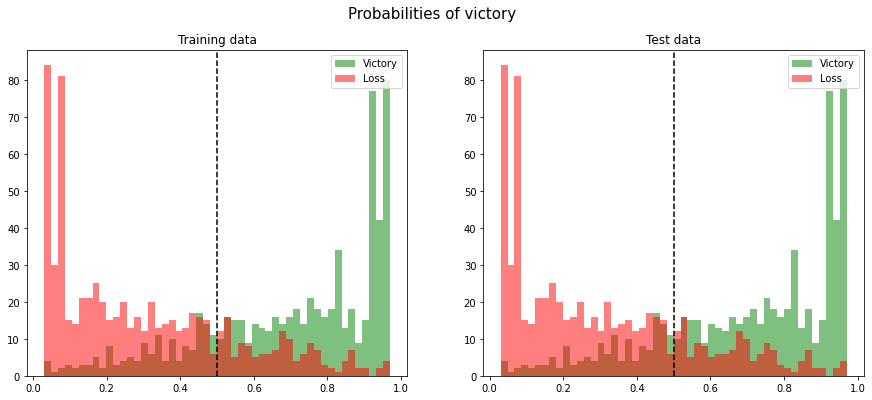

In [27]:
report_points(xgb_train, xgb_train, xgb_target, xgb_target, xgb_index['oof_pointpred'], xgb_index['oof_pointpred'], plot=True)

In [28]:
xgb_index['oof_pred'], xgb_res['xgb_pred'] = _point_to_proba(xgb_index['oof_pointpred'], xgb_index['target'], xgb_res['xgb_pointpred'])

In [29]:
xgb_res.head()

,ID,Team1,Team2,Season,xgb_pointpred,xgb_pred
0,2022_3107_3110,3107,3110,2022,-2.773844,0.418872
1,2022_3107_3112,3107,3112,2022,-25.091692,0.030000
2,2022_3107_3116,3107,3116,2022,-15.284582,0.107324
3,2022_3107_3124,3107,3124,2022,-28.236186,0.046553
4,2022_3107_3125,3107,3125,2022,-17.572841,0.071014


<AxesSubplot:>

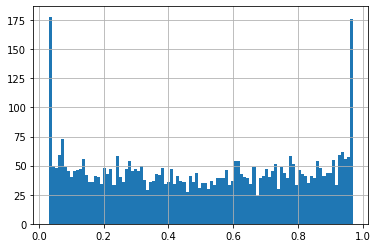

In [30]:
xgb_res['xgb_pred'].hist(bins=100)

# Combining

Accord: 	0.9285714285714286
Logit: 		0.4232514248079204
Xgb: 		0.45160636039903945
Mean: 		0.43059873112334224
Boost sure: 	0.44130006577757197
Boost sure+mean: 0.4427173621013596
No uncertain: 0.4583543994787995
Accuracy train: 		 0.7965
Accuracy test: 			 0.7944
Logloss train: 			 0.4413
Logloss test: 			 0.4311
Unsure train: 			 15.4401%
Unsure test: 			 17.2439%


,ID,Team1,Team2,target,Season,logit_pred,target_points,oof_pointpred,xgb_pred,mean_pred,accord_win,accord_loss,accord,boostsure,avg_boost,no_uncertain
0,2010_3124_3201,3124,3201,1,2010,0.991338,14,14.152137,0.872858,0.932098,1,0,1,0.970000,0.970000,0.970000
1,2010_3173_3395,3173,3395,1,2010,0.512749,1,1.051416,0.532275,0.522512,1,0,1,0.512749,0.522512,0.612749
2,2010_3181_3214,3181,3214,1,2010,0.998246,35,25.911751,0.970000,0.984123,1,0,1,0.970000,0.970000,0.970000
3,2010_3199_3256,3199,3256,1,2010,0.990309,14,20.379112,0.960907,0.975608,1,0,1,0.970000,0.970000,0.970000
4,2010_3207_3265,3207,3265,1,2010,0.647250,20,6.214503,0.681666,0.664458,1,0,1,0.647250,0.664458,0.747250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,2021_3400_3376,3400,3376,0,2021,0.113259,-28,-11.142666,0.193138,0.153199,0,1,1,0.030000,0.030000,0.030000
1382,2021_3390_3257,3390,3257,1,2021,0.697890,15,9.220035,0.761626,0.729758,1,0,1,0.697890,0.729758,0.797890
1383,2021_3163_3112,3163,3112,0,2021,0.891421,-10,22.591030,0.970000,0.930710,1,0,1,0.970000,0.970000,0.970000
1384,2021_3390_3376,3390,3376,1,2021,0.487221,1,1.978600,0.559734,0.523478,0,0,0,0.487221,0.487221,0.487221


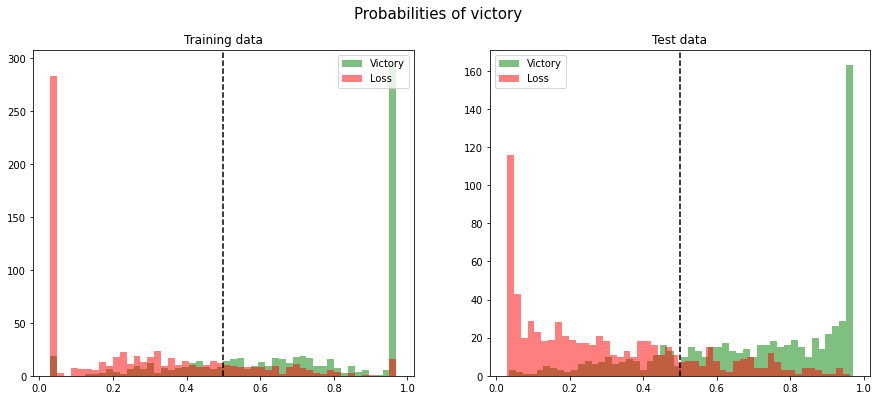

In [31]:
logit_index.rename(columns={'oof_pred': 'logit_pred'}, inplace=True)
xgb_index.rename(columns={'oof_pred': 'xgb_pred'}, inplace=True)

all_pred = pd.merge(logit_index, xgb_index, on=['ID', 'Team1', 'Team2', 'Season', 'target'])
lim = 0.3
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

all_pred['boostsure'] = all_pred.logit_pred

all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

all_pred['no_uncertain'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              ((all_pred.logit_pred < 0.5+lim) | (all_pred.xgb_pred < 0.5+lim))), 'no_uncertain'] = all_pred['no_uncertain'] + 0.1
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              ((all_pred.logit_pred > 0.5-lim) | (all_pred.xgb_pred > 0.5-lim))), 'no_uncertain'] = all_pred['no_uncertain'] - 0.1
all_pred['no_uncertain'] = np.clip(all_pred['no_uncertain'], 0.03, 0.97)


print(f'Accord: \t{all_pred.accord.mean()}')
print(f'Logit: \t\t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.target)}')
print(f'Xgb: \t\t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.target)}')
print(f'Mean: \t\t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.target)}')
print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.target)}')
print(f'Boost sure+mean: {log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.target)}')
print(f'No uncertain: {log_loss(y_pred=all_pred.no_uncertain, y_true=all_pred.target)}')
report_victory(all_pred.target, all_pred.target, all_pred.boostsure, all_pred.mean_pred, probs=True, plot=True)
all_pred

In [32]:
all_pred = pd.merge(logit_res, xgb_res, on=['ID', 'Team1', 'Team2', 'Season'])
lim = 0.3
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

all_pred['boostsure'] = all_pred.logit_pred

all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

all_pred['no_uncertain'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              ((all_pred.logit_pred < 0.5+lim) | (all_pred.xgb_pred < 0.5+lim))), 'no_uncertain'] = all_pred['no_uncertain'] + 0.05
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              ((all_pred.logit_pred > 0.5-lim) | (all_pred.xgb_pred > 0.5-lim))), 'no_uncertain'] = all_pred['no_uncertain'] - 0.05
all_pred['no_uncertain'] = np.clip(all_pred['no_uncertain'], 0.03, 0.97)

all_pred

,ID,Team1,Team2,Season,logit_pred,xgb_pointpred,xgb_pred,mean_pred,accord_win,accord_loss,accord,boostsure,avg_boost,no_uncertain
0,2022_3107_3110,3107,3110,2022,0.508802,-2.773844,0.418872,0.463837,0,0,0,0.508802,0.508802,0.508802
1,2022_3107_3112,3107,3112,2022,0.079158,-25.091692,0.030000,0.054579,0,1,1,0.030000,0.030000,0.030000
2,2022_3107_3116,3107,3116,2022,0.201741,-15.284582,0.107324,0.154533,0,1,1,0.201741,0.201741,0.151741
3,2022_3107_3124,3107,3124,2022,0.033674,-28.236186,0.046553,0.040113,0,1,1,0.030000,0.030000,0.030000
4,2022_3107_3125,3107,3125,2022,0.175972,-17.572841,0.071014,0.123493,0,1,1,0.030000,0.030000,0.030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,2022_3439_3428,3439,3428,2022,0.577180,2.745331,0.582310,0.579745,1,0,1,0.577180,0.579745,0.627180
4552,2022_3450_3428,3450,3428,2022,0.465011,-4.149765,0.378790,0.421900,0,1,1,0.465011,0.421900,0.415011
4553,2022_3439_3437,3439,3437,2022,0.693554,9.708439,0.773879,0.733716,1,0,1,0.693554,0.733716,0.743554
4554,2022_3450_3437,3450,3437,2022,0.516138,0.937943,0.528906,0.522522,1,0,1,0.516138,0.522522,0.566138


array([[<AxesSubplot:title={'center':'Team1'}>,
        <AxesSubplot:title={'center':'Team2'}>,
        <AxesSubplot:title={'center':'Season'}>,
        <AxesSubplot:title={'center':'logit_pred'}>],
       [<AxesSubplot:title={'center':'xgb_pointpred'}>,
        <AxesSubplot:title={'center':'xgb_pred'}>,
        <AxesSubplot:title={'center':'mean_pred'}>,
        <AxesSubplot:title={'center':'accord_win'}>],
       [<AxesSubplot:title={'center':'accord_loss'}>,
        <AxesSubplot:title={'center':'accord'}>,
        <AxesSubplot:title={'center':'boostsure'}>,
        <AxesSubplot:title={'center':'avg_boost'}>],
       [<AxesSubplot:title={'center':'no_uncertain'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

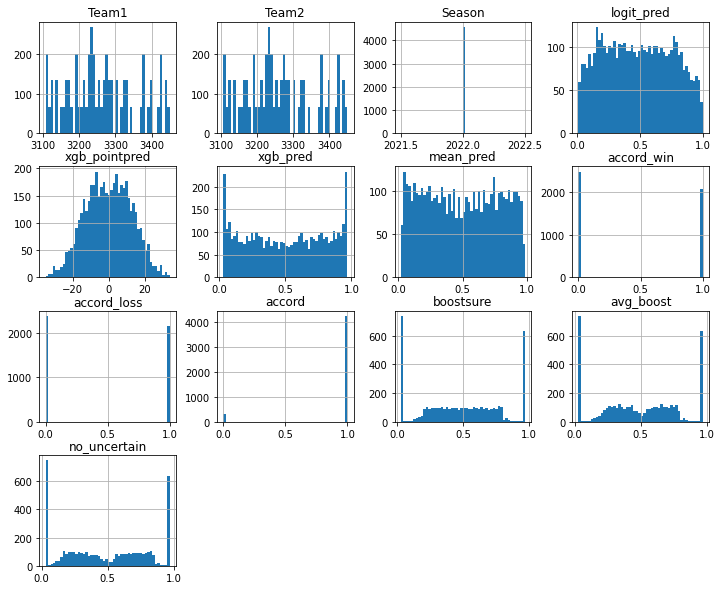

In [33]:
all_pred.hist(bins=50, figsize=(12, 10))


# Spread submission

In [33]:
normal_scores = xgb_res[xgb_res.Team1 < xgb_res.Team2]#[['ID', 'Team1', 'Team2', 'xgb_pred', 'xgb_pointpred']]
opp_scores = xgb_res[xgb_res.Team1 > xgb_res.Team2].copy()#[['ID', 'Team1', 'Team2', 'xgb_pred', 'xgb_pointpred']].copy()
opp_scores.drop(['ID', 'Season'], axis=1, inplace=True)
tot_scores = pd.merge(normal_scores, opp_scores, left_on=['Team1', 'Team2'], right_on=['Team2', 'Team1'])
tot_scores['xgb_preds'] = (tot_scores['xgb_pred_x'] + 1 -  tot_scores['xgb_pred_y']) / 2
tot_scores['Pred'] = round((tot_scores['xgb_pointpred_x'] -  tot_scores['xgb_pointpred_y']) / 2, 0).astype(int)

tot_scores[['ID', 'Pred']].to_csv('oof/2021_women_submission_spread.csv', index=False)

tot_scores.head()

,ID,Team1_x,Team2_x,Season,xgb_pointpred_x,xgb_pred_x,Team1_y,Team2_y,xgb_pointpred_y,xgb_pred_y,xgb_preds,Pred
0,2021_3104_3112,3104,3112,2021,-5.260330,0.339919,3112,3104,4.150386,0.624003,0.357958,-5
1,2021_3104_3116,3104,3116,2021,-5.703027,0.327050,3116,3104,3.807417,0.613805,0.356622,-5
2,2021_3104_3124,3104,3124,2021,-21.125140,0.030000,3124,3104,22.935925,0.970000,0.030000,-22
3,2021_3104_3125,3104,3125,2021,-0.349561,0.487689,3125,3104,-0.361801,0.487315,0.500187,0
4,2021_3104_3133,3104,3133,2021,-0.475886,0.483827,3133,3104,-0.800907,0.473893,0.504967,0


# Main submission

In [39]:
normal_scores = all_pred[all_pred.Team1 < all_pred.Team2]
opp_scores = all_pred[all_pred.Team1 > all_pred.Team2].copy()
opp_scores.drop(['ID', 'Season'], axis=1, inplace=True)
tot_scores = pd.merge(normal_scores, opp_scores, left_on=['Team1', 'Team2'], right_on=['Team2', 'Team1'])
tot_scores['mean_pred'] = (tot_scores['mean_pred_x'] + 1 -  tot_scores['mean_pred_y']) / 2
tot_scores['boostsure'] = (tot_scores['boostsure_x'] + 1 -  tot_scores['boostsure_y']) / 2
tot_scores['avg_boost'] = (tot_scores['avg_boost_x'] + 1 -  tot_scores['avg_boost_y']) / 2
tot_scores['logit'] = (tot_scores['logit_pred_x'] + 1 -  tot_scores['logit_pred_y']) / 2

tot_scores.rename(columns={'Team1_x': 'Team1', 'Team2_x': 'Team2'}, inplace=True)

tot_scores = tot_scores[['ID', 'Team1', 'Team2', 'mean_pred', 'boostsure', 'avg_boost', 'logit']].copy()

tot_scores = pd.merge(tot_scores, 
                      test_df[['Team1', 'Team2', 'T1_Seed', 'T2_Seed'] + [col for col in test_df if 'stage' in col]], 
                      on=['Team1', 'Team2'], how='left')

teams = pd.read_csv('data/raw_women/WDataFiles_Stage2/WTeams.csv')[['TeamID', 'TeamName']]

teams.rename(columns={'TeamID': 'Team1', 'TeamName': 'Name1'}, inplace=True)
tot_scores = pd.merge(tot_scores, teams, on='Team1', how='left')
teams.rename(columns={'Team1': 'Team2', 'Name1': 'Name2'}, inplace=True)
tot_scores = pd.merge(tot_scores, teams, on='Team2', how='left')

tot_scores

,ID,Team1,Team2,mean_pred,boostsure,avg_boost,logit,T1_Seed,T2_Seed,stage_Round1,stage_Round2,stage_Round3,stage_Round4,stage_final,stage_finalfour,stage_impossible,Name1,Name2
0,2022_3107_3110,3107,3110,0.477153,0.528381,0.528381,0.528381,16.0,14.0,0,0,0,1,0,0,0,SUNY Albany,American Univ
1,2022_3107_3112,3107,3112,0.061514,0.030000,0.030000,0.093028,16.0,4.0,0,0,0,0,0,1,0,SUNY Albany,Arizona
2,2022_3107_3116,3107,3116,0.165847,0.225617,0.225617,0.225617,16.0,10.0,0,0,0,0,1,0,0,SUNY Albany,Arkansas
3,2022_3107_3124,3107,3124,0.044918,0.030000,0.030000,0.043205,16.0,2.0,0,0,0,1,0,0,0,SUNY Albany,Baylor
4,2022_3107_3125,3107,3125,0.132574,0.120349,0.120349,0.193335,16.0,12.0,0,0,1,0,0,0,0,SUNY Albany,Belmont
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2022_3428_3439,3428,3439,0.409155,0.408066,0.409155,0.408066,7.0,5.0,0,0,0,1,0,0,0,Utah,Virginia Tech
2274,2022_3428_3450,3428,3450,0.556241,0.513397,0.534952,0.513397,7.0,8.0,0,0,0,0,0,1,0,Utah,Washington St
2275,2022_3437_3439,3437,3439,0.254663,0.289450,0.254663,0.289450,11.0,5.0,0,0,0,0,1,0,0,Villanova,Virginia Tech
2276,2022_3437_3450,3437,3450,0.467031,0.467132,0.467031,0.467132,11.0,8.0,0,0,0,0,1,0,0,Villanova,Washington St


In [40]:
tot_scores[['ID', 'mean_pred']].rename(columns={'mean_pred':'Pred'}).to_csv('oof/2022_women_sub_mean.csv', index=False)
tot_scores[['ID', 'logit']].rename(columns={'logit':'Pred'}).to_csv('oof/2022_women_sub_logit.csv', index=False)

In [35]:
def find_match(team1, team2):
    res = tot_scores[(tot_scores.Name1.str.contains(team1) & tot_scores.Name2.str.contains(team2)) | 
                     (tot_scores.Name2.str.contains(team1) & tot_scores.Name1.str.contains(team2))]
    return res

In [123]:
find_match('Conn', 'South C')

,ID,Team1,Team2,mean_pred,boostsure,avg_boost,T1_Seed,T2_Seed,stage_Round1,stage_Round2,stage_Round3,stage_Round4,stage_final,stage_finalfour,Name1,Name2
510,2021_3163_3376,3163,3376,0.728404,0.629651,0.629651,1.0,1.0,0,0,0,0,1,0,Connecticut,South Carolina


In [36]:
adjusted = tot_scores.copy()
adjusted.loc[(adjusted.Team1 == 3390) & (adjusted.Team2 == 3430), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3283) & (adjusted.Team2 == 3413), 'Pred'] = 0.87
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3460), 'Pred'] = 0.97
adjusted.loc[(adjusted.Team1 == 3332) & (adjusted.Team2 == 3377), 'Pred'] = 0.80
adjusted.loc[(adjusted.Team1 == 3180) & (adjusted.Team2 == 3208), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3321) & (adjusted.Team2 == 3416), 'Pred'] = 0.85
adjusted.loc[(adjusted.Team1 == 3257) & (adjusted.Team2 == 3265), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3163) & (adjusted.Team2 == 3219), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3355) & (adjusted.Team2 == 3393), 'Pred'] = 0.30  #############
adjusted.loc[(adjusted.Team1 == 3226) & (adjusted.Team2 == 3246), 'Pred'] = 0.07
adjusted.loc[(adjusted.Team1 == 3195) & (adjusted.Team2 == 3276), 'Pred'] = 0.30  #############
adjusted.loc[(adjusted.Team1 == 3292) & (adjusted.Team2 == 3397), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3266) & (adjusted.Team2 == 3439), 'Pred'] = 0.30
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3238), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3199) & (adjusted.Team2 == 3333), 'Pred'] = 0.30  #############
adjusted.loc[(adjusted.Team1 == 3210) & (adjusted.Team2 == 3372), 'Pred'] = 0.30  ###########
adjusted.loc[(adjusted.Team1 == 3133) & (adjusted.Team2 == 3400), 'Pred'] = 0.30  ###### or do nothing
adjusted.loc[(adjusted.Team1 == 3417) & (adjusted.Team2 == 3461), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3104) & (adjusted.Team2 == 3314), 'Pred'] = 0.30  ##########
adjusted.loc[(adjusted.Team1 == 3378) & (adjusted.Team2 == 3450), 'Pred'] = 0.30  ##########
adjusted.loc[(adjusted.Team1 == 3231) & (adjusted.Team2 == 3433), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3112) & (adjusted.Team2 == 3392), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3235) & (adjusted.Team2 == 3277), 'Pred'] = 0.70   ######### or do nothing
adjusted.loc[(adjusted.Team1 == 3400) & (adjusted.Team2 == 3407), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3283), 'Pred'] = 0.70   #########
adjusted.loc[(adjusted.Team1 == 3208) & (adjusted.Team2 == 3332), 'Pred'] = 0.30   ##########
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3439), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3372) & (adjusted.Team2 == 3452), 'Pred'] = 0.30  ############
adjusted.loc[(adjusted.Team1 == 3268) & (adjusted.Team2 == 3314), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3211) & (adjusted.Team2 == 3231), 'Pred'] = 0.30   ########## or do nothing
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3390), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3163) & (adjusted.Team2 == 3246), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3397), 'Pred'] = 0.95
adjusted.loc[(adjusted.Team1 == 3353) & (adjusted.Team2 == 3401), 'Pred'] = 0.65  ########### or do nothing
adjusted.loc[(adjusted.Team1 == 3372) & (adjusted.Team2 == 3452), 'Pred'] = 0.30  ############ or do nothing
adjusted.loc[(adjusted.Team1 == 3301) & (adjusted.Team2 == 3353), 'Pred'] = 0.70  ##### or do nothing
adjusted.loc[(adjusted.Team1 == 3376) & (adjusted.Team2 == 3390), 'Pred'] = 0.30  ############ 

adjusted.loc[adjusted.Pred.isna(), 'Pred'] = adjusted.mean_pred
adjusted[['ID', 'Pred']].to_csv('oof/2021_women_submission.csv', index=False)

In [37]:
adjusted = tot_scores.copy()
adjusted.loc[(adjusted.Team1 == 3390) & (adjusted.Team2 == 3430), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3283) & (adjusted.Team2 == 3413), 'Pred'] = 0.87
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3460), 'Pred'] = 0.97
adjusted.loc[(adjusted.Team1 == 3332) & (adjusted.Team2 == 3377), 'Pred'] = 0.80
adjusted.loc[(adjusted.Team1 == 3180) & (adjusted.Team2 == 3208), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3321) & (adjusted.Team2 == 3416), 'Pred'] = 0.85
adjusted.loc[(adjusted.Team1 == 3257) & (adjusted.Team2 == 3265), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3163) & (adjusted.Team2 == 3219), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3355) & (adjusted.Team2 == 3393), 'Pred'] = 0.70  #############
adjusted.loc[(adjusted.Team1 == 3226) & (adjusted.Team2 == 3246), 'Pred'] = 0.07
adjusted.loc[(adjusted.Team1 == 3195) & (adjusted.Team2 == 3276), 'Pred'] = 0.70  #############
adjusted.loc[(adjusted.Team1 == 3292) & (adjusted.Team2 == 3397), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3266) & (adjusted.Team2 == 3439), 'Pred'] = 0.30
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3238), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3199) & (adjusted.Team2 == 3333), 'Pred'] = 0.70  #############
adjusted.loc[(adjusted.Team1 == 3210) & (adjusted.Team2 == 3372), 'Pred'] = 0.70  ###########
adjusted.loc[(adjusted.Team1 == 3133) & (adjusted.Team2 == 3400), 'Pred'] = 0.30  ###### or do nothing
adjusted.loc[(adjusted.Team1 == 3417) & (adjusted.Team2 == 3461), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3104) & (adjusted.Team2 == 3314), 'Pred'] = 0.70  ##########
adjusted.loc[(adjusted.Team1 == 3378) & (adjusted.Team2 == 3450), 'Pred'] = 0.70  ##########
adjusted.loc[(adjusted.Team1 == 3231) & (adjusted.Team2 == 3433), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3112) & (adjusted.Team2 == 3392), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3400) & (adjusted.Team2 == 3407), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3283), 'Pred'] = 0.30   #########
adjusted.loc[(adjusted.Team1 == 3208) & (adjusted.Team2 == 3332), 'Pred'] = 0.70   ##########
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3439), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3372) & (adjusted.Team2 == 3452), 'Pred'] = 0.70  ############
adjusted.loc[(adjusted.Team1 == 3268) & (adjusted.Team2 == 3314), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3116) & (adjusted.Team2 == 3390), 'Pred'] = 0.02
adjusted.loc[(adjusted.Team1 == 3163) & (adjusted.Team2 == 3246), 'Pred'] = 0.98
adjusted.loc[(adjusted.Team1 == 3124) & (adjusted.Team2 == 3397), 'Pred'] = 0.95
adjusted.loc[(adjusted.Team1 == 3376) & (adjusted.Team2 == 3390), 'Pred'] = 0.70  ############ 

adjusted.loc[adjusted.Pred.isna(), 'Pred'] = adjusted.mean_pred
adjusted[['ID', 'Pred']].to_csv('oof/2021_women_submission_alt.csv', index=False)

In [39]:
first_sub = pd.read_csv('oof/2021_women_submission.csv')
second_sub = pd.read_csv('oof/2021_women_submission_alt.csv')

all_sub = pd.merge(first_sub, second_sub, on='ID')



,ID,Pred_x,Pred_y
34,2021_3104_3314,0.30,0.700000
152,2021_3116_3283,0.70,0.300000
602,2021_3195_3276,0.30,0.700000
665,2021_3199_3333,0.30,0.700000
715,2021_3208_3332,0.30,0.700000
769,2021_3210_3372,0.30,0.700000
793,2021_3211_3231,0.30,0.456222
1035,2021_3235_3277,0.70,0.518562
1586,2021_3301_3353,0.70,0.572001
1750,2021_3353_3401,0.65,0.547493
